In [115]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import smogn
import seaborn as sns

In [238]:
seed = 3

In [186]:
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, mean_squared_log_error
def evaluate(y_pred, y_test):
    """ Prints out the evaluation metrics of the experiment
        parameters:
            y_pred
                DataFrame or array-like, the predictions
            y_test
                DataFrame or array-like, the actual y-values
                
            these two parameters must have the same dimensions
    """
    print("r^2: ", r2_score(y_test, y_pred))
    print("mse: ", mean_squared_error(y_test, y_pred))
    print("variance_score: ", explained_variance_score(y_test, y_pred))
    print("mse-log: ", mean_squared_log_error(y_test, y_pred))

In [187]:
def run(model, model_name, x_train, x_val):
    """ Fits the model and prints out results from calling evaluate on the training and validation set
        parameters:
            model
                the unfitted model, from sklearn (has to have a fit and predict method)
            model_name
                String, the name of the model
            x_train
                DataFrame, the training set
            x_val
                DataFrame, the validation set
                
        returns:
            nothing
        
    """
    model = model.fit(x_train, y_train)
    y_pred = np.clip(model.predict(x_train), 0, 1000) # since negative results are meaningless
    
    print("[{0}] These are the results for the training set.".format(model_name))
    
    evaluate(y_pred, y_train)
    print("--------------------------------------")
    
    print("[{0}] These are the results for the validation set.".format(model_name))
    y_pred = np.clip(model.predict(x_val), 0, 1000) # since negative results are meaningless
    
    evaluate(y_pred, y_val)
    
    print("_____________________________________________")

In [247]:
df = pd.read_excel("../spring21_data/fa_stats_v3.xlsx")
df = df[df['poss'] >= 500]
injury = pd.read_excel("../spring21_data/season_ending_injury.xlsx")
injury_fa = df.merge(right=injury, how='inner', left_on=['clean_season', 'Player'], right_on=['clean_season', 'Player']).rename(columns={'Unnamed: 0': 'index'})
df = df[~df['Unnamed: 0'].isin(injury_fa['index'])]
df = df.select_dtypes(exclude=['object'])
df.drop(columns=["Unnamed: 0", "Minutes", "salary", "clean_season", "age", "end season_y", "season_end"], inplace=True)

X = df.drop(columns=["cap_space_usage"])
y = df["cap_space_usage"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=seed)
both = pd.concat([X_train, y_train], axis=1).reset_index().drop(columns=["index"])
smote_data_high = smogn.smoter(data = both,
                           y = 'cap_space_usage',
                           rel_xtrm_type = 'high',
                           rel_thres = 0.85,
                           k = 11,
                           drop_na_col = True,       ## boolean (True or False)
                           drop_na_row = True,
                           samp_method = 'balance')
smote_data_mid = smogn.smoter(data = both,
                           y = 'cap_space_usage',
                           rel_xtrm_type = 'both',
                           rel_thres = 0.25,
                           k = 11,
                           drop_na_col = True,       ## boolean (True or False)
                           drop_na_row = True,
                           samp_method = 'extreme')
smote_data_low = smogn.smoter(data = both,
                           y = 'cap_space_usage',
                           rel_xtrm_type = 'both',
                           rel_thres = 0.001,
                           k = 11,
                           drop_na_col = True,       ## boolean (True or False)
                           drop_na_row = True,
                           samp_method = 'extreme')
smote_data = pd.concat([smote_data_high, smote_data_mid, smote_data_low], ignore_index=True).drop_duplicates()
sm = smote_data.sample(frac=1) ## make sure to shuffle the rows otherwise the cross validation will be scuffed
y = sm[['cap_space_usage']]
X = sm.drop(columns=['cap_space_usage'])

r_index: 100%|##########| 27/27 [00:00<00:00, 299.72it/s]


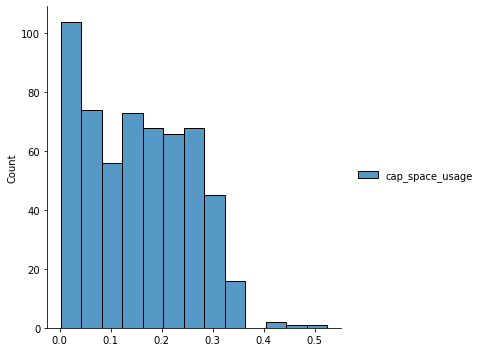

In [248]:
sns.displot(y)

In [249]:
from sklearn.feature_selection import SelectKBest, f_regression
select = SelectKBest(f_regression, k=45)

best_features = select.fit_transform(X, y)
feature_scores = pd.concat([pd.Series(X.columns), pd.Series(select.scores_)], axis=1)
feature_scores.columns = ["features", "score"]
features = list(feature_scores.sort_values(by=["score"], ascending=False).head(25)['features'])

D:\Users\chengmingliu\Anaconda3\envs\nba-model\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [194]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in tree
n_estimators = range(25, 450, 15)

# Maximum number of levels in tree
max_depth = range(3, 10, 2)

min_child_weight = range(1,7)
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_child_weight': min_child_weight,
               'gamma':[i/10.0 for i in range(0,20)],
               'colsample_bytree': [i/100.0 for i in range(60, 90, 5)],
               'learning_rate': [i/100.0 for i in range(5, 20, 5)],
               'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]}

In [195]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
xgb = XGBRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
xgb_random = RandomizedSearchCV(estimator = xgb, param_distributions = random_grid, n_iter = 300, cv = 7, verbose=3, random_state=seed, n_jobs = -1)
# Fit the random search model
xgb_random.fit(X_train, y_train)

Fitting 7 folds for each of 300 candidates, totalling 2100 fits


RandomizedSearchCV(cv=7,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n...
                   n_iter=300, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.65, 0.7,
                                                             0.75, 0.8,

In [197]:
xgb_random.best_params_

{'reg_alpha': 1e-05,
 'n_estimators': 235,
 'min_child_weight': 2,
 'max_depth': 3,
 'learning_rate': 0.15,
 'gamma': 0.0,
 'colsample_bytree': 0.8}

In [78]:
reg_alpha= 1e-05,
 n_estimators= 235,
 min_child_weight= 2,
 max_depth= 3,
 learning_rate= 0.15,
 gamma= 0.0,
 colsample_bytree= 0.8

{'reg_alpha': 1e-05}

In [250]:
xgb = XGBRegressor(reg_alpha= 1e-05,
 n_estimators= 335,
 min_child_weight= 2,
 max_depth= 3,
 learning_rate= 0.15,
 gamma= 0.0,
 colsample_bytree= 0.75)

run(xgb, "XGB", X_train[features], X_val[features])

[XGB] These are the results for the training set.
r^2:  0.9997984966264358
mse:  1.2442649581664238e-06
variance_score:  0.9997984969066619
mse-log:  1.0768120481642415e-06
--------------------------------------
[XGB] These are the results for the validation set.
r^2:  0.8060094065121647
mse:  0.0022548907005845785
variance_score:  0.8325100578170372
mse-log:  0.0016280992250265335
_____________________________________________


In [251]:
evaluate(xgb.predict(X_test[features]), y_test)

r^2:  0.7851823454827249
mse:  0.0017543089612584036
variance_score:  0.7910333952251198
mse-log:  0.0013656174096295275


In [252]:
data = pd.read_excel("../spring21_data/fa_stats_v3.xlsx")

In [253]:
test_index = X_test.index
test_data = data.iloc[test_index][['clean_season','Player','MPG', 'attempted_field_goals', 'minutes_played', 'WS', 'Wins Added', 'poss','cap_space_usage']]
results = pd.concat([test_data, pd.DataFrame(index=test_index, data=xgb.predict(X_test[features]))], axis=1)

In [254]:
results

,clean_season,Player,MPG,attempted_field_goals,minutes_played,WS,Wins Added,poss,cap_space_usage,0
250,2018,Luc Mbah a Moute,25.6,5.655738,25.639344,2.8,2.345739,3541,0.042412,0.072775
353,2019,Markieff Morris,21.9,9.647059,25.970588,1.6,0.060003,2841,0.020541,0.024235
87,2016,Jason Terry,17.5,5.222222,17.472222,1.5,0.185474,2883,0.016482,0.031512
32,2016,Matthew Dellavedova,24.6,6.723684,24.565789,3.8,3.885353,4174,0.102052,0.071801
318,2019,Cory Joseph,25.2,6.682927,25.158537,3.5,4.323144,4453,0.109951,0.082163
247,2018,Aaron Gordon,32.9,14.913793,32.913793,2.9,4.144279,3994,0.206147,0.174316
72,2016,Tyler Johnson,24.0,6.750000,23.972222,2.0,0.677395,1806,0.059781,0.057193
60,2016,Dewayne Dedmon,12.2,3.051724,12.155172,2.4,1.009431,1434,0.030783,0.031737
15,2016,David West,18.0,5.743590,18.000000,5.4,3.495108,3163,0.016482,0.070158
268,2018,Tony Parker,19.5,7.054545,19.472727,1.4,0.142373,2302,0.049083,0.040519
